In [1]:
from utils_v1 import *

from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    DeforestationTime, MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates, 
    MT, MTDeforestationTime
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
import matplotlib.pyplot as plt
import matplotlib

from tifffile import imsave
import src.rasterHandler as rasterHandler


In [2]:
addPastDeforestationInput = True

# threshold_uncertainty = 0.15
threshold_uncertainty = 0.1

# dataset = MTDeforestationTime()
dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)
if type(dataset) != ParaMultipleDates:
	patchesHandler = PatchesHandler()
else:
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)

save_probabilities = True
loadInference = True

if type(dataset) == ParaMultipleDates:
	exp = 11 # Multiple dates. using fixed fixed past deforestation distance
	exp = 22
	exp = 50
	exp = 52
	# exp = 54
	exp = 56
	exp = 58
	# exp = 63
	# exp = 52
	# exp = 64
	# exp = 66
	exp = 66
	exp = 68
	# exp = 69
	# exp = 70
	exp = 72
if type(dataset) == MTDeforestationTime:
	exp = 28
elif type(dataset) == ParaMultipleDates:
	# exp = 72 # train 2015-2018
	# exp = 69 # train 2016-2018
	# exp = 70 # train 2017-2018
	
	
	exp = 39 # train 2018-2019. test 2018-2019

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [3]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([0, 1], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| self.paths.labelFromProject: 'D:/Jorge/datasets/deforestation/Para_2018_2019/mask_label_17730x9203.npy'
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


(-0.5, 9202.5, 17729.5, -0.5)

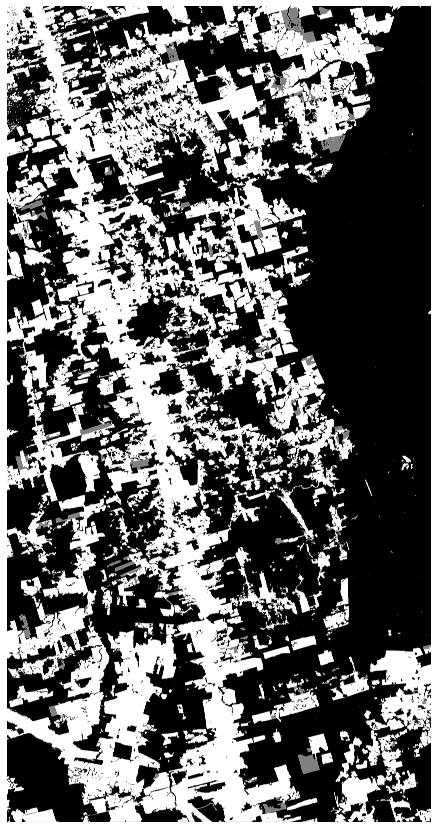

In [4]:
plt.figure(figsize=(15,15))
plt.imshow(label_mask, cmap=plt.cm.gray)
plt.axis('off')


In [5]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [6]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [7]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [8]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [9]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [10]:
if not issubclass(type(dataset), DeforestationTime):
    patchesHandler.dataset.image_channels[-1]

In [11]:
if issubclass(type(dataset), MultipleDates):
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [12]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp39'

In [13]:
channels

21

In [14]:
image_stack.shape

(17730, 9200, 21)

In [15]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	# image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	# label_mask = label_mask[...,-1]

In [16]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-30.0 -16.0


In [17]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp39/models/resunet_0.h5'


In [18]:
del image1_pad


In [19]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)



0
1
2
3
4
5
6
7
8
9


In [20]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [21]:
label_mask.shape

(17730, 9200)

In [22]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]

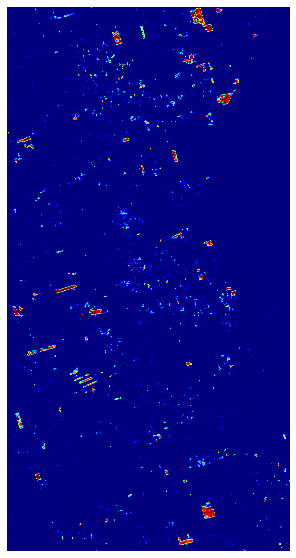

In [23]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [24]:
print(label_mask.shape)

(17730, 9200)


In [25]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54253101,)
(array([0, 1], dtype=uint8), array([53486282,   766819], dtype=int64))


In [26]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [27]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [28]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [29]:
print(mean_prob.shape)

# threshold = 0.420339
threshold = 0.5

predicted = np.zeros_like(mean_prob)

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

(17730, 9200)
(array([0., 1.], dtype=float32), array([161151281,   1964719], dtype=int64))


(-0.5, 9199.5, 17729.5, -0.5)

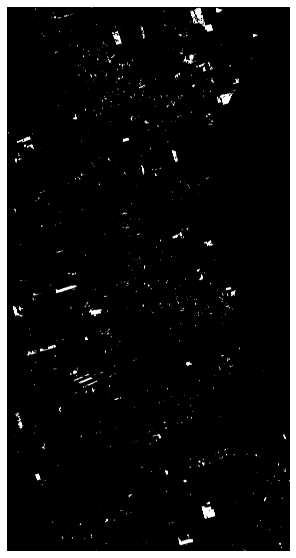

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(predicted, cmap = plt.cm.gray)
plt.axis('off')

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [32]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.014020843
    np.max(prob_rec): 1.0


(0.0, 0.014020843, 1.0)

In [33]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [34]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.007498527
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 2.9265182e-16
    np.mean(pred_entropy): 0.008282974
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [35]:
import utils_v1
label_mask_test = label_mask[mask_amazon_ts == 1]
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
y_pred = pred_entropy_test

In [36]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))

ic| np.min(y_pred): 4.6412976e-15
    np.mean(y_pred): 0.009420509
    np.max(y_pred): 0.36787948


(4.6412976e-15, 0.009420509, 0.36787948)

In [37]:
importlib.reload(_metrics)


predicted_thresholded = np.zeros_like(y_pred).astype(np.int8)
predicted_thresholded[y_pred >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54253101,)


(54253101,)

In [38]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52688449,  1564652], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100946294,   1842066,  60327640], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52688449,  1564652], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100946294,   1842066,  60327640], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [39]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    # total_test_area = mask_test.copy()
    # total_test_area[label_mask == 2] = 0
    total_test_area = mask_test[label_mask != 2] 
    total_test_area = total_test_area[total_test_area == 1]
    ic(uncertainty_mask.flatten().shape, total_test_area.shape)
    percentage = np.count_nonzero(uncertainty_mask.flatten()) / len(total_test_area.flatten())
    return total_test_area, percentage

ic(predicted_thresholded.shape, label_mask.shape, mask_amazon_ts.shape, label_mask.flatten().shape)
total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| predicted_thresholded.shape: (54253101,)
    label_mask.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.flatten().shape: (163116000,)
ic| uncertainty_mask.flatten().shape: (54253101,)
    total_test_area.shape: (54253101,)
ic| percentage: 0.028839862996955696


0.028839862996955696

In [40]:

pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)



uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1

ignoreSmallPolygons = False
if ignoreSmallPolygons == True:
    min_polygon_area = 625 # pixels
    ic(np.unique(uncertainty_mask, return_counts=True))

    uncertainty_mask_without_small_polygons = skimage.morphology.area_opening(uncertainty_mask, 
        area_threshold = min_polygon_area, connectivity=1)

    
ic(np.unique(uncertainty_mask, return_counts=True))



ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([158976324,   4139676], dtype=int64))


(array([0, 1], dtype=int8), array([158976324,   4139676], dtype=int64))

In [41]:
# cv2.imwrite("uncertainty_mask_without_small_polygons.png", uncertainty_mask_without_small_polygons*255)
# cv2.imwrite("uncertainty_mask.png", uncertainty_mask*255)


In [42]:
# ic(np.min(image_stack[...,[13,12,11]]), np.mean(image_stack[...,[13,12,11]]), np.max(image_stack[...,[13,12,11]]))


In [43]:
# plt.figure(figsize=(10,10))
# plt.imshow(image_stack[...,[13,12,11]])
# plt.axis('off')



In [44]:
# cv2.imwrite("MT_sentinel2_t0_rgb.png", image_stack[...,[3,2,1]])
## cv2.imwrite("MT_sentinel2_t0_rgb.png", (image_stack[...,[3,2,1]]*255).astype(np.uint8))
# cv2.imwrite("MT_sentinel2_t1_rgb.png", (image_stack[...,[13,12,11]]*255).astype(np.uint8))


In [45]:
# cv2.imwrite("MT_sentinel2_t0_rgb.png", (image_stack[...,[3,2,1]]*255).astype(np.uint8))

In [46]:
ic(pred_entropy_unpad.shape, label_mask.shape)

ic| pred_entropy_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [47]:
'''
def getUncertaintyMask(uncertainty):

    uncertainty_mask = np.zeros_like(uncertainty).astype(np.uint8)
    uncertainty_mask[uncertainty >= 0.15] = 1
    return uncertainty_mask
def maskOutPastDeforestation(uncertainty_mask, label_mask):
    uncertainty_mask[label_mask == 2] = 0
    return uncertainty_mask

uncertainty_mask = getUncertaintyMask(pred_entropy_unpad)
uncertainty_mask = maskOutPastDeforestation(uncertainty_mask, label_mask)
ic(np.unique(uncertainty_mask, return_counts=True))
'''

'\ndef getUncertaintyMask(uncertainty):\n\n    uncertainty_mask = np.zeros_like(uncertainty).astype(np.uint8)\n    uncertainty_mask[uncertainty >= 0.15] = 1\n    return uncertainty_mask\ndef maskOutPastDeforestation(uncertainty_mask, label_mask):\n    uncertainty_mask[label_mask == 2] = 0\n    return uncertainty_mask\n\nuncertainty_mask = getUncertaintyMask(pred_entropy_unpad)\nuncertainty_mask = maskOutPastDeforestation(uncertainty_mask, label_mask)\nic(np.unique(uncertainty_mask, return_counts=True))\n'

In [48]:
'''
uncertainty_mask_test = uncertainty_mask[mask_amazon_ts==1]
label_test = label_mask[mask_amazon_ts==1]

uncertainty_mask_test = uncertainty_mask_test[label_test!=2]

ic(uncertainty_mask_test.shape)
'''

'\nuncertainty_mask_test = uncertainty_mask[mask_amazon_ts==1]\nlabel_test = label_mask[mask_amazon_ts==1]\n\nuncertainty_mask_test = uncertainty_mask_test[label_test!=2]\n\nic(uncertainty_mask_test.shape)\n'

In [49]:
prob_rec.shape

(10, 17760, 9216, 1)

(-0.5, 9215.5, 17759.5, -0.5)

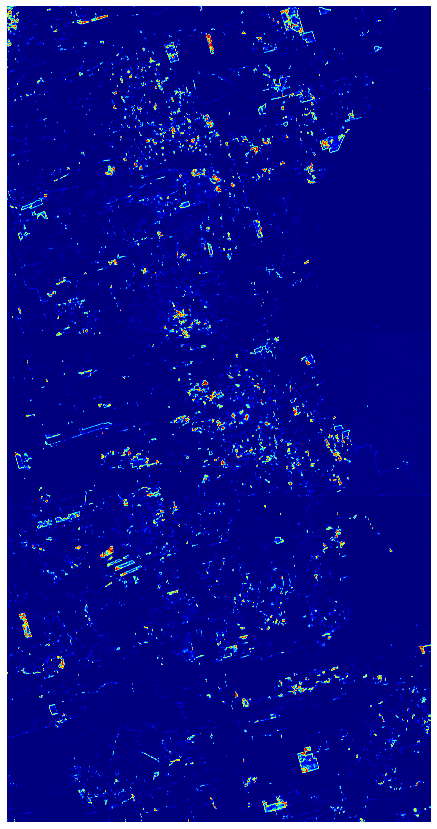

In [50]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


In [51]:
np.mean(pred_entropy)

0.008282974

In [52]:
# mean_prob.shape
pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].shape

(17730, 9200)

In [53]:
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(pred_entropy): 2.9265182e-16
    np.mean(pred_entropy): 0.008282974
    np.max(pred_entropy): 0.36787948


(2.9265182e-16, 0.008282974, 0.36787948)

In [54]:
predicted = np.zeros_like(mean_prob).astype(np.uint8)
threshold = 0.5
predicted[mean_prob>=threshold] = 1
min_polygon_area = 625
predicted_without_small_polygons = skimage.morphology.area_opening(predicted, 
        area_threshold = min_polygon_area, connectivity=1)

predicted_small_polygons = predicted - predicted_without_small_polygons


In [55]:
pred_entropy_to_show[predicted_small_polygons == 1] = 0
ic(pred_entropy_to_show.shape)

ic| pred_entropy_to_show.shape: (17730, 9200)


(17730, 9200)

(-0.5, 9199.5, 17729.5, -0.5)

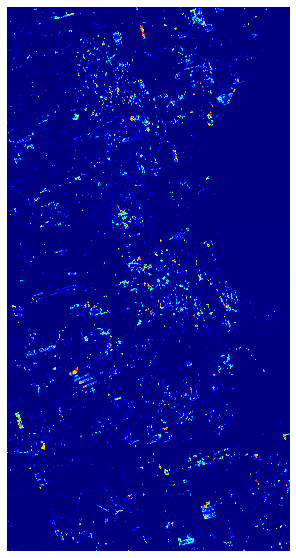

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


In [57]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0071677393
    np.max(pred_entropy_to_show): 0.36787948


(0.0, 0.0071677393, 0.36787948)

In [58]:

georreferenced_save = False

In [59]:
import utils_v1
import rasterio

if georreferenced_save == True:
    georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')

In [60]:
if georreferenced_save == True:
    georref_im.shape

In [61]:
ic(pred_entropy_unpad.shape, pred_entropy.shape)
ic(predicted.shape, label_mask.shape)

ic| pred_entropy_unpad.shape: (17730, 9200)
    pred_entropy.shape: (17760, 9216)
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [62]:
prediced_to_show = predicted.copy()
prediced_to_show[label_mask == 2] = 0

label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

false_positive_mask = prediced_to_show - label_mask_current_deforestation
false_positive_mask = (false_positive_mask + 1).astype(np.int8)
ic(np.unique(false_positive_mask, return_counts=True))

ic| np.unique(false_positive_mask, return_counts=True): (array([0, 1, 2], dtype=int8),
                                                         array([   242378, 162508591,    365031], dtype=int64))


(array([0, 1, 2], dtype=int8),
 array([   242378, 162508591,    365031], dtype=int64))

In [63]:
if georreferenced_save == True:
    original_im_path = 'D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif'

## Save georreferenced images

In [64]:
if georreferenced_save == True:

    pred_entropy_to_show_pad = rasterHandler.padForGeorreferencing(pred_entropy_to_show)

    ic(np.min(pred_entropy_to_show_pad), np.mean(pred_entropy_to_show_pad), np.max(pred_entropy_to_show_pad))

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(pred_entropy_to_show_pad, cmap='jet')
    plt.axis('off')

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_uncertainty_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(pred_entropy_to_show_pad, axis=0).astype(np.float32), produced_im_path, bands = 1,
                    nodata=-1)

In [65]:
if georreferenced_save == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_false_positive_mask_georreferenced.tif'
    false_positive_mask_pad = rasterHandler.padForGeorreferencing(false_positive_mask, pad_value = 255)
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(false_positive_mask_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

In [66]:
if georreferenced_save == True:

    label_mask_pad = rasterHandler.padForGeorreferencing(label_mask, pad_value = 255)
    label_mask_pad.dtype

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_ground_truth_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(label_mask_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

    predicted_pad = rasterHandler.padForGeorreferencing(predicted, pad_value = 255)
    predicted_pad.dtype
    predicted_pad[label_mask_pad == 2] = 2

    ic(np.unique(predicted_pad, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_predicted_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(predicted_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

                

In [67]:

if georreferenced_save == True:

    im_t0_pad = rasterHandler.padForGeorreferencingChannels(image_stack[...,[3,2,1]])
    im_t0_pad = np.transpose(im_t0_pad, (2, 0, 1))
    print(np.min(image_stack[...,[13,12,11]]), np.mean(image_stack[...,[13,12,11]]), np.max(image_stack[...,[13,12,11]]))


    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_sentinel2_2019_rgb_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_t0_pad.astype(np.float32), produced_im_path, bands = 3,
                    nodata=-1)

    im_t1_pad = rasterHandler.padForGeorreferencingChannels(image_stack[...,[13,12,11]])
    im_t1_pad = np.transpose(im_t1_pad, (2, 0, 1))
    print(im_t1_pad.shape)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_sentinel2_2020_rgb_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_t1_pad.astype(np.float32), produced_im_path, bands = 3,
                    nodata=-1)
    

In [68]:
uncertainty_mask.dtype

dtype('int8')

In [69]:


if georreferenced_save == True:
    uncertainty_mask_pad = rasterHandler.padForGeorreferencingChannels(uncertainty_mask)
    uncertainty_mask_pad = np.transpose(uncertainty_mask_pad, (2, 0, 1))

    uncertainty_mask_without_small_polygons_pad = rasterHandler.padForGeorreferencingChannels(
        uncertainty_mask_without_small_polygons)
    uncertainty_mask_without_small_polygons_pad = np.transpose(
        uncertainty_mask_without_small_polygons_pad, (2, 0, 1))

(-0.5, 9199.5, 17729.5, -0.5)

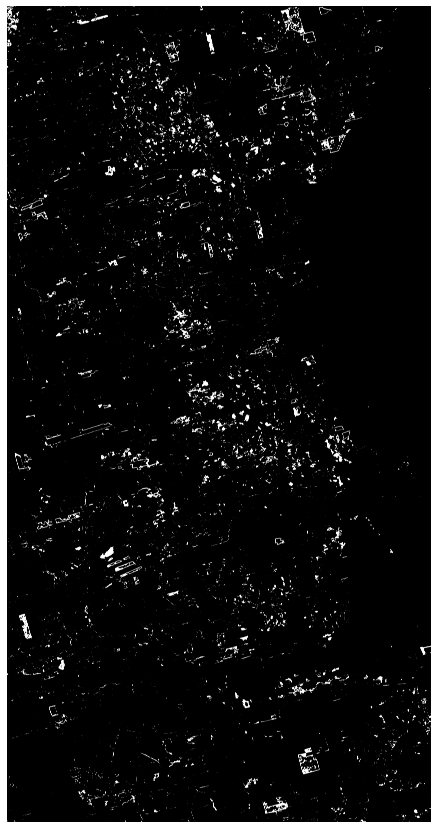

In [70]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [71]:
ic(np.unique(uncertainty_mask, return_counts=True))

ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([158976324,   4139676], dtype=int64))


(array([0, 1], dtype=int8), array([158976324,   4139676], dtype=int64))

In [72]:
# contours, _ = cv2.findContours(uncertainty_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);

In [73]:
# len(contours)

In [74]:
# for con in contours:
#     area = cv2.contourArea(con);
#     print(area)

In [75]:
connectivity = 4  
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    uncertainty_mask, connectivity, cv2.CV_32S)


In [76]:
ic(num_labels)

ic| num_labels: 16493


16493

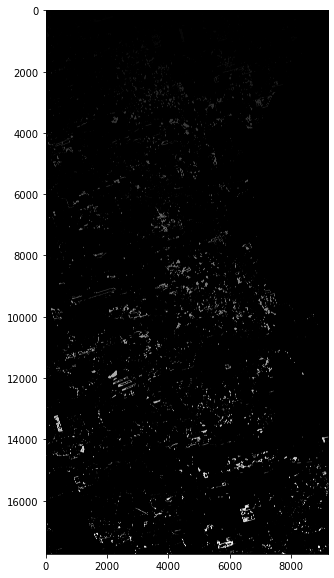

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap = plt.cm.gray)

In [78]:
area = stats[1:,-1]

In [79]:
stats[44:55]

array([[ 5933,    22,   776,   782, 86684],
       [ 3452,    25,     1,     1,     1],
       [ 7714,    25,    15,    59,   303],
       [  108,    33,     2,     2,     4],
       [   88,    33,    51,    61,  1003],
       [  167,    34,     2,     3,     3],
       [ 3459,    37,     4,     4,    10],
       [ 3053,    39,     2,     5,     6],
       [ 4173,    39,     7,     4,    14],
       [ 4181,    41,     1,     1,     1],
       [ 3463,    43,     7,    18,    57]], dtype=int32)

In [80]:
ic(np.min(area),np.mean(area),np.max(area))

ic| np.min(area): 1
    np.mean(area): 251.0111569245695
    np.max(area): 86684


(1, 251.0111569245695, 86684)

In [81]:
np.argmax(area)

43

In [82]:
area.shape

(16492,)

In [83]:
if issubclass(type(dataset), MT):
    bin_n = 435
elif issubclass(type(dataset), Para):
    bin_n = 140
bin_n

140

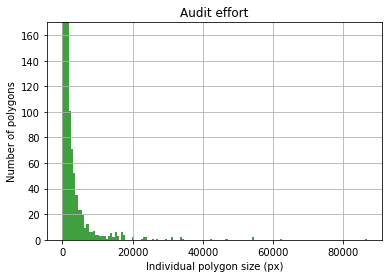

In [84]:
import matplotlib.pyplot as plt
# bin_n = 450
n, bins, patches = plt.hist(area, bin_n, facecolor='g', alpha=0.75)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Number of polygons')
plt.title('Audit effort')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(-100, 2000)
plt.ylim(0, 170)
plt.grid(True)
plt.show()

In [85]:
# print(bins)

In [86]:
# ic(bins, bins[2]-bins[1], bins[3]-bins[2], bins[4]-bins[3])
bin_size = round(bins[2]-bins[1], 1)
ic(bin_size)

ic| bin_size: 619.2


619.2

In [87]:
import pdb
def getBinAreaSum(areas, bin_n, bin_size):
    areaSumPerBin = []
    for bin_id in range(bin_n):
        areaSum = 0
        for area in areas:
            if area > bin_size * bin_id and area < bin_size * (bin_id + 1):
                areaSum = areaSum + area
                # print(areaSum)
                # pdb.set_trace()
        areaSumPerBin.append(areaSum)
    return areaSumPerBin
        


areaSumPerBin = getBinAreaSum(area, bin_n, bin_size)    
ic(areaSumPerBin)

ic| areaSumPerBin: [713473,
                    362748,
                    299398,
                    218156,
                    195061,
                    175808,
                    142198,
                    105902,
                    120363,
                    110709,
                    57720,
                    85465,
                    46796,
                    49710,
                    62253,
                    38193,
                    40630,
                    32498,
                    33973,
                    36111,
                    12891,
                    39460,
                    69603,
                    29165,
                    90671,
                    47716,
                    0,
                    101855,
                    70643,
                    0,
                    0,
                    0,
                    40771,
                    0,
                    0,
                    0,
                    22854,
                  

[713473,
 362748,
 299398,
 218156,
 195061,
 175808,
 142198,
 105902,
 120363,
 110709,
 57720,
 85465,
 46796,
 49710,
 62253,
 38193,
 40630,
 32498,
 33973,
 36111,
 12891,
 39460,
 69603,
 29165,
 90671,
 47716,
 0,
 101855,
 70643,
 0,
 0,
 0,
 40771,
 0,
 0,
 0,
 22854,
 46005,
 47582,
 0,
 0,
 25436,
 0,
 27082,
 0,
 0,
 0,
 29702,
 0,
 0,
 63079,
 0,
 0,
 0,
 67393,
 34162,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 42212,
 0,
 0,
 0,
 0,
 0,
 0,
 46687,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 108388,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 62470,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 86684]

In [88]:
bins

array([1.00000000e+00, 6.20164286e+02, 1.23932857e+03, 1.85849286e+03,
       2.47765714e+03, 3.09682143e+03, 3.71598571e+03, 4.33515000e+03,
       4.95431429e+03, 5.57347857e+03, 6.19264286e+03, 6.81180714e+03,
       7.43097143e+03, 8.05013571e+03, 8.66930000e+03, 9.28846429e+03,
       9.90762857e+03, 1.05267929e+04, 1.11459571e+04, 1.17651214e+04,
       1.23842857e+04, 1.30034500e+04, 1.36226143e+04, 1.42417786e+04,
       1.48609429e+04, 1.54801071e+04, 1.60992714e+04, 1.67184357e+04,
       1.73376000e+04, 1.79567643e+04, 1.85759286e+04, 1.91950929e+04,
       1.98142571e+04, 2.04334214e+04, 2.10525857e+04, 2.16717500e+04,
       2.22909143e+04, 2.29100786e+04, 2.35292429e+04, 2.41484071e+04,
       2.47675714e+04, 2.53867357e+04, 2.60059000e+04, 2.66250643e+04,
       2.72442286e+04, 2.78633929e+04, 2.84825571e+04, 2.91017214e+04,
       2.97208857e+04, 3.03400500e+04, 3.09592143e+04, 3.15783786e+04,
       3.21975429e+04, 3.28167071e+04, 3.34358714e+04, 3.40550357e+04,
      

In [89]:
matplotlib.rcParams.update({'font.size': 16})


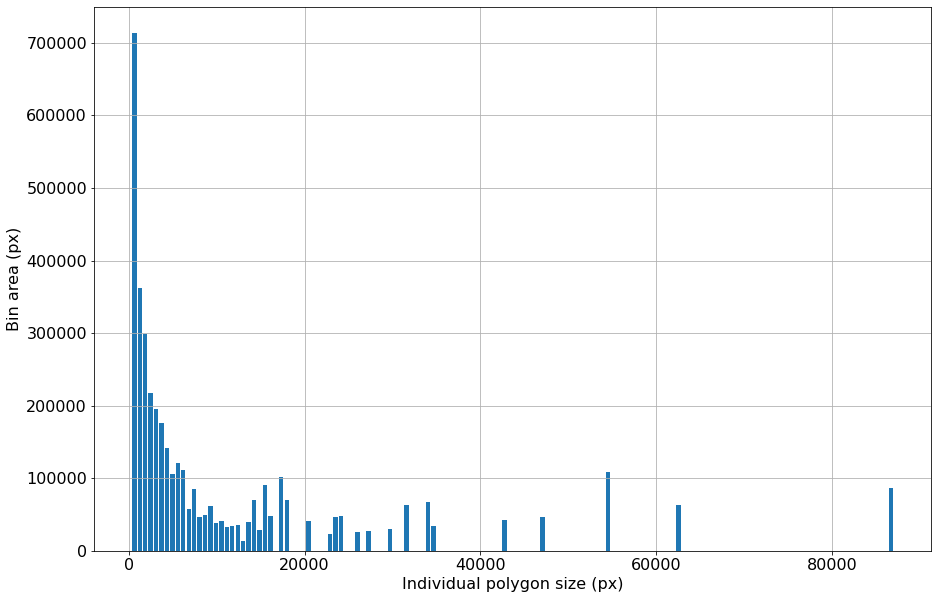

In [90]:

plt.figure(figsize = (15,10))
width = 500
plt.bar(bins[1:], areaSumPerBin, width)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Bin area (px)')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('figures/polygon_area_sum_per_bin.png', dpi=150, bbox_inches='tight')

In [91]:
ic(bins.shape, n.shape)

ic| bins.shape: (141,), n.shape: (140,)


((141,), (140,))

In [92]:
ic(np.sum(n))

ic(np.sum(n) - n[0])

ic| np.sum(n): 16492.0
ic| np.sum(n) - n[0]: 1044.0


1044.0

In [93]:
bins[1:]

array([  620.16428571,  1239.32857143,  1858.49285714,  2477.65714286,
        3096.82142857,  3715.98571429,  4335.15      ,  4954.31428571,
        5573.47857143,  6192.64285714,  6811.80714286,  7430.97142857,
        8050.13571429,  8669.3       ,  9288.46428571,  9907.62857143,
       10526.79285714, 11145.95714286, 11765.12142857, 12384.28571429,
       13003.45      , 13622.61428571, 14241.77857143, 14860.94285714,
       15480.10714286, 16099.27142857, 16718.43571429, 17337.6       ,
       17956.76428571, 18575.92857143, 19195.09285714, 19814.25714286,
       20433.42142857, 21052.58571429, 21671.75      , 22290.91428571,
       22910.07857143, 23529.24285714, 24148.40714286, 24767.57142857,
       25386.73571429, 26005.9       , 26625.06428571, 27244.22857143,
       27863.39285714, 28482.55714286, 29101.72142857, 29720.88571429,
       30340.05      , 30959.21428571, 31578.37857143, 32197.54285714,
       32816.70714286, 33435.87142857, 34055.03571429, 34674.2       ,
      

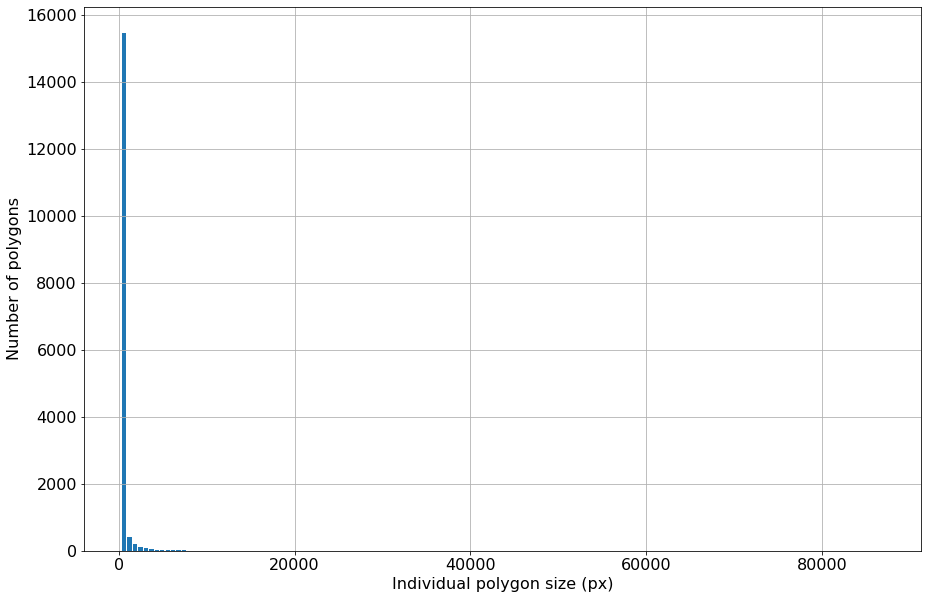

In [94]:

plt.figure(figsize = (15,10))
plt.bar(bins[1:], n, width)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Number of polygons')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('figures/polygon_bin_area.png', dpi=150, bbox_inches='tight')

In [95]:
def getCumulativeArea(areaSumPerBin):
    cumulativeArea = []
    cumulativeSum = 0
    for areaSum in areaSumPerBin[::-1]:
        cumulativeSum = cumulativeSum + areaSum
        cumulativeArea.append(cumulativeSum)
    return np.asarray(cumulativeArea)[::-1]



cumulativeArea = getCumulativeArea(areaSumPerBin)
ic(cumulativeArea.shape)

ic| cumulativeArea.shape: (140,)


(140,)

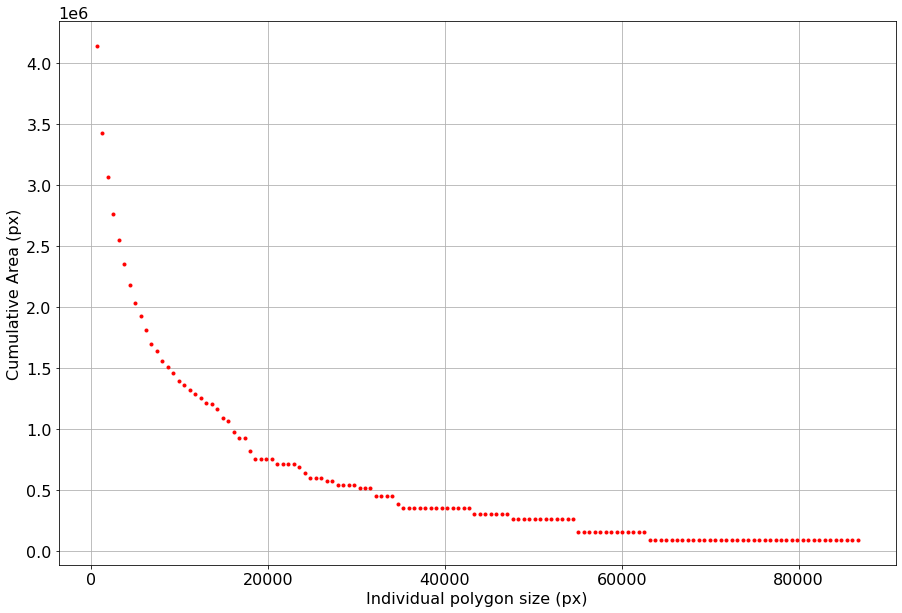

In [96]:

plt.figure(figsize = (15,10))
plt.plot(bins[1:], cumulativeArea,'r.')


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Cumulative Area (px)')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('figures/polygon_cumulative_area.png', dpi=150, bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

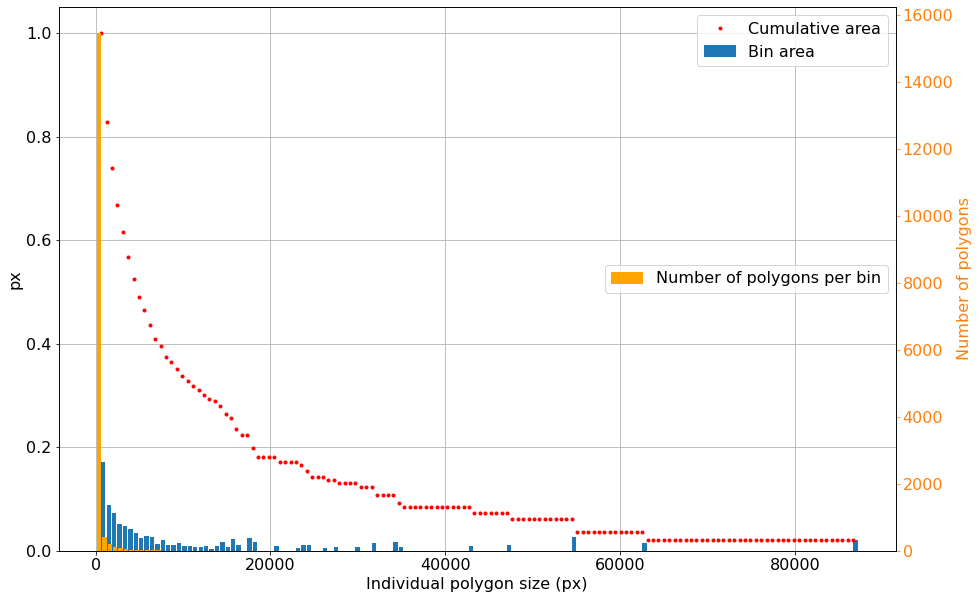

In [97]:


plt.figure(figsize = (15,10))

# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax2 = ax1.twinx()

ax1.bar(bins[1:]+width/2, areaSumPerBin/cumulativeArea[0], width, label = 'Bin area')
ax1.plot(bins[1:], cumulativeArea/cumulativeArea[0],'r.', label = 'Cumulative area')

ax1.set_xlabel('Individual polygon size (px)')
ax1.set_ylabel('px')
ax1.legend(loc = 'upper right')

ax2.bar(bins[1:]-width/2, n, width, color = 'orange', label = 'Number of polygons per bin')
ax2.legend(loc = 'center right')
ax2.set_ylabel('Number of polygons', color="C1")
ax2.tick_params(axis='y', colors='C1')

# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
ax1.grid(True)
plt.savefig('figures/polygon_analysis.png', dpi=150, bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

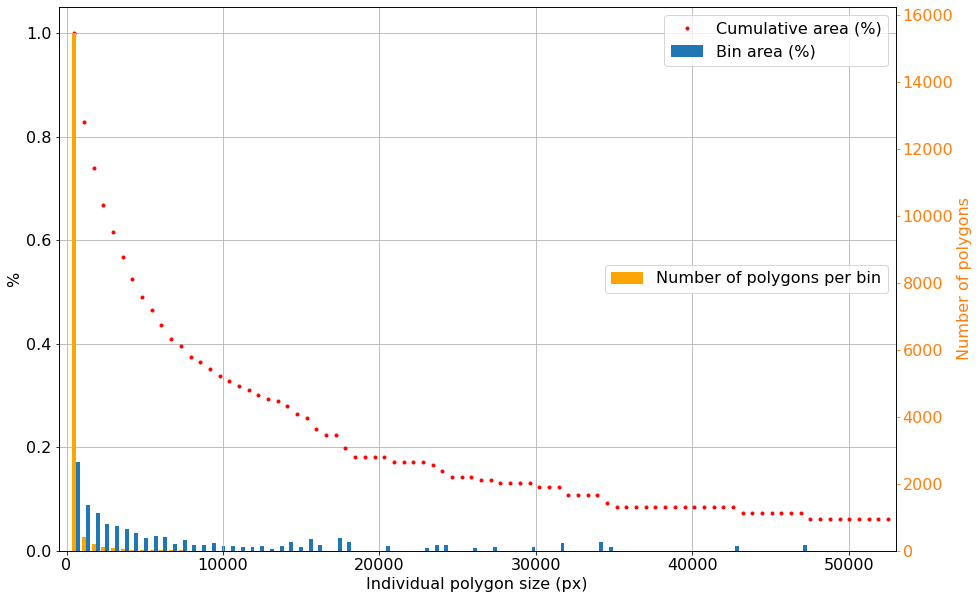

In [98]:


plt.figure(figsize = (15,10))
width = 250
# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax2 = ax1.twinx()

ax1.bar(bins[1:]+width/2, areaSumPerBin/cumulativeArea[0], width, label = 'Bin area (%)')
ax1.plot(bins[1:]-width/2, cumulativeArea/cumulativeArea[0],'r.', label = 'Cumulative area (%)')

ax1.set_xlabel('Individual polygon size (px)')
ax1.set_ylabel('%')
ax1.legend(loc = 'upper right')

ax2.bar(bins[1:]-width/2, n, width, color = 'orange', label = 'Number of polygons per bin')
ax2.legend(loc = 'center right')
ax2.set_ylabel('Number of polygons', color="C1")
ax2.tick_params(axis='y', colors='C1')

ax1.set_xlim([-500, 53000])
ax2.set_xlim([-500, 53000])

# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
ax1.grid(True)
plt.savefig('figures/polygon_analysis_percentage.png', dpi=150, bbox_inches='tight')

In [99]:
bins

array([1.00000000e+00, 6.20164286e+02, 1.23932857e+03, 1.85849286e+03,
       2.47765714e+03, 3.09682143e+03, 3.71598571e+03, 4.33515000e+03,
       4.95431429e+03, 5.57347857e+03, 6.19264286e+03, 6.81180714e+03,
       7.43097143e+03, 8.05013571e+03, 8.66930000e+03, 9.28846429e+03,
       9.90762857e+03, 1.05267929e+04, 1.11459571e+04, 1.17651214e+04,
       1.23842857e+04, 1.30034500e+04, 1.36226143e+04, 1.42417786e+04,
       1.48609429e+04, 1.54801071e+04, 1.60992714e+04, 1.67184357e+04,
       1.73376000e+04, 1.79567643e+04, 1.85759286e+04, 1.91950929e+04,
       1.98142571e+04, 2.04334214e+04, 2.10525857e+04, 2.16717500e+04,
       2.22909143e+04, 2.29100786e+04, 2.35292429e+04, 2.41484071e+04,
       2.47675714e+04, 2.53867357e+04, 2.60059000e+04, 2.66250643e+04,
       2.72442286e+04, 2.78633929e+04, 2.84825571e+04, 2.91017214e+04,
       2.97208857e+04, 3.03400500e+04, 3.09592143e+04, 3.15783786e+04,
       3.21975429e+04, 3.28167071e+04, 3.34358714e+04, 3.40550357e+04,
      

In [100]:
ic(np.sum(n), np.sum(n[1:]), np.sum(n[2:]))


ic| np.sum(n): 16492.0, np.sum(n[1:]): 1044.0, np.sum(n[2:]): 632.0


(16492.0, 1044.0, 632.0)

In [101]:
ic(labels.shape, label_mask.shape)

ic| labels.shape: (17730, 9200), label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

(-0.5, 9199.5, 17729.5, -0.5)

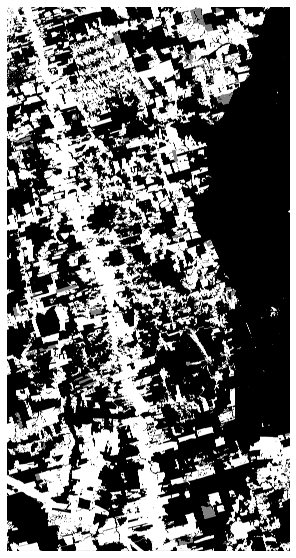

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 9199.5, 17729.5, -0.5)

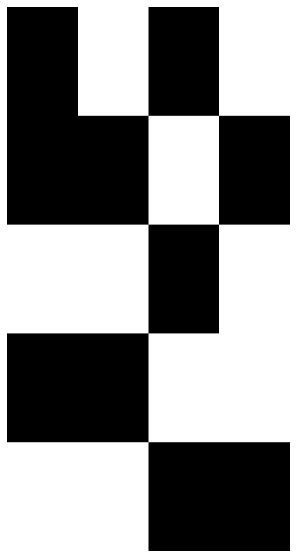

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(mask_amazon_ts, cmap=plt.cm.gray)
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

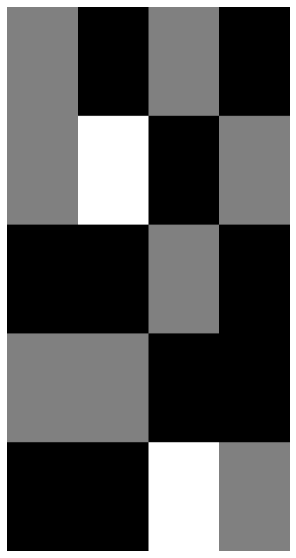

In [104]:
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val, cmap=plt.cm.gray)
plt.axis('off')


In [105]:
label_current_deforestation = label_mask.copy()
label_current_deforestation[label_current_deforestation == 2] = 0
label_current_deforestation = label_current_deforestation.astype(np.bool)

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_2496\2548657025.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_current_deforestation = label_current_deforestation.astype(np.bool)


In [106]:
ic(np.unique(uncertainty_mask, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))


ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([158976324,   4139676], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100946294,   1842066,  60327640], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=int8), array([158976324,   4139676], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100946294,   1842066,  60327640], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [107]:
'''
plt.figure(figsize=(10,10))
plt.imshow(total_test_area, cmap=plt.cm.gray)
plt.axis('off')
'''

"\nplt.figure(figsize=(10,10))\nplt.imshow(total_test_area, cmap=plt.cm.gray)\nplt.axis('off')\n"

In [108]:
def countIntersectingPolygons(labels, deforestation_polygons):
    ic(np.max(labels))
    count_intersecting_polygons = 0

    for polygon_id in range(np.max(labels)):
        if polygon_id % 500 == 0:
            print(polygon_id, count_intersecting_polygons)
        polygon_mask = labels.copy()
        polygon_mask[polygon_mask != polygon_id] = 0
        polygon_mask = polygon_mask.astype(np.bool)

        
        if np.any(polygon_mask & deforestation_polygons):
            count_intersecting_polygons += 1
    return count_intersecting_polygons

# count_intersecting_polygons = countIntersectingPolygons(labels, label_current_deforestation)
count_intersecting_polygons = countIntersectingPolygons(labels, predicted.astype(np.bool))

ic(count_intersecting_polygons)

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_2496\4215946958.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  count_intersecting_polygons = countIntersectingPolygons(labels, predicted.astype(np.bool))
ic| np.max(labels): 16492


0 0


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_2496\4215946958.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  polygon_mask = polygon_mask.astype(np.bool)


500 125
1000 180
1500 219
2000 281
2500 323
3000 375
3500 442
4000 477
4500 500
5000 548
5500 595
6000 621
6500 640
7000 666
7500 705
8000 733
8500 771
9000 812
9500 871
10000 907
10500 941
11000 981
11500 1024
12000 1064
12500 1101
13000 1142
13500 1168
14000 1208
14500 1268
15000 1296
15500 1451
16000 1478


ic| count_intersecting_polygons: 1573


1573

In [109]:
count_intersecting_polygons/np.max(labels)

0.09537957797720106